# Advanced Lane Finding

In [3]:
import os
import cv2
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
# kill axis in rcParams
#print(mpl.rcParams.keys())
mpl.rc('image', interpolation='bilinear')
mpl.rc('axes.spines',top=False,bottom=False,left=False,right=False);
mpl.rc('axes',facecolor=(1,1,1,0),edgecolor=(1,1,1,0));
mpl.rc(('xtick','ytick'),color=(1,1,1,0));
# enlarge default figure size
mpl.rc('figure', figsize=(10, 5))

Magic constants

In [4]:
# number of chessboard joints in each direction
NX = 9
NY = 6

# directory with camera calibration images
CAM_CAL_DIR = "camera_cal"

# directory for output images
OUT_DIR = "output_images"

# directory with test images
IN_DIR = "test_images"

## Calibrating camera

The following block performs camera calibration using OpenCV framework and an image directory, supplied with the task

camera_cal/calibration1.jpg
camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration12.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration15.jpg
Just FYI the shape of calibration15.jpg is (721, 1281) does not match previous images shape (720, 1280)
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration18.jpg
camera_cal/calibration19.jpg
camera_cal/calibration2.jpg
camera_cal/calibration20.jpg
camera_cal/calibration3.jpg
camera_cal/calibration4.jpg
camera_cal/calibration5.jpg
camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
Just FYI the shape of calibration7.jpg is (721, 1281) does not match previous images shape (720, 1280)
camera_cal/calibration8.jpg
camera_cal/calibration9.jpg
Camera matrix: [[  1.15396093e+03   0.00000000e+00   6.69705357e+02]
 [  0.00000000e+00   1.14802496e+03   3.85656234e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Lens distortion coefficients: [[ -2.41017956

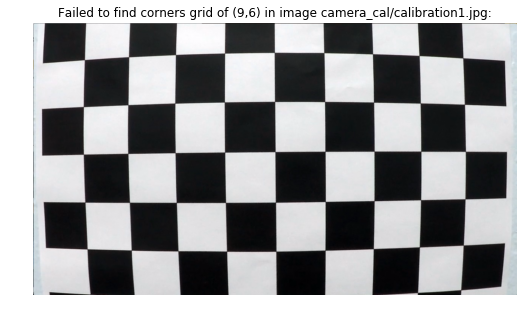

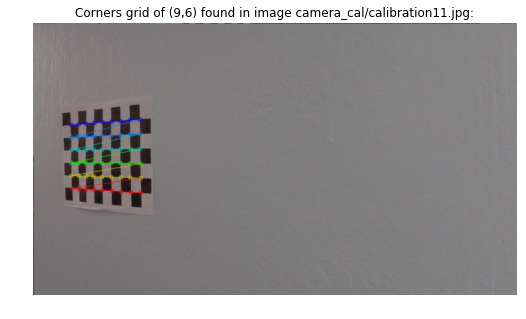

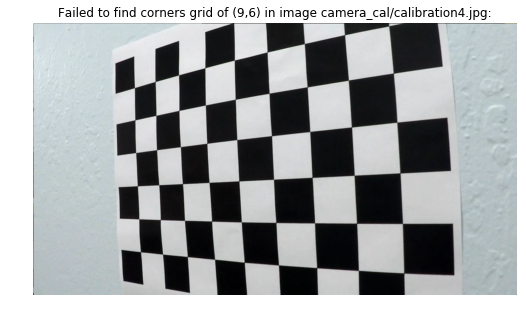

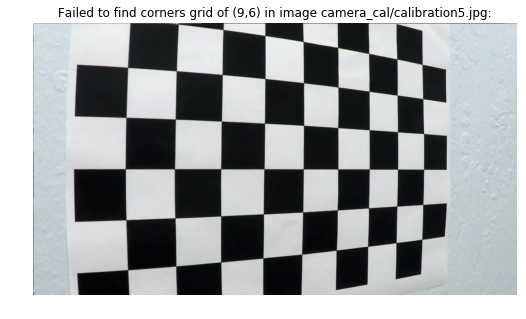

In [5]:
def extractCornersOne(path, bPlot=False):
    print(path)
    img = cv2.imread(path)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (NX, NY), None)

    if not ret:
        corners = None
        fig = plt.figure()
        plt.title('Failed to find corners grid of ({},{}) in image {}:'.format(NX, NY, path))
        plt.imshow(img)
    elif bPlot:
        cv2.drawChessboardCorners(img, (NX, NY), corners, ret)
        fig = plt.figure()
        plt.title('Corners grid of ({},{}) found in image {}:'.format(NX, NY, path))
        plt.imshow(img)
        
    return corners, gray.shape

def extractCornersDir(path):
    corners = []
    i = 0
    shapeAll = None
    for img in os.listdir(path):
        cornersImg, shape = extractCornersOne(CAM_CAL_DIR + '/' + img, i == 1)
        if cornersImg is None:
            continue

        if shapeAll is None:
            shapeAll = shape
        elif shapeAll != shape:
            print('Just FYI the shape of {} is {} does not match previous images shape {}'.format(img, shape, shapeAll))
            
        corners.append(cornersImg)
        i += 1
    return corners, shapeAll

def calibrateCameraUsingImages(path):
    # create fixed representation of chessboard in the object space
    ptsObj = np.zeros((NX*NY, 3), np.float32)
    ptsObj[:,:2] = np.mgrid[0:NX, 0:NY].T.reshape(-1, 2)

    ptsImg, imgShape = extractCornersDir(path)
    
    #make sure there is a copy of object space for every image space feature sets
    ptsObj = [ptsObj] * len(ptsImg)

    ret, Mcam, dist, rvecs, tvecs = cv2.calibrateCamera(ptsObj, ptsImg, imgShape[::-1], None, None)
    return Mcam, dist

Mcam, dist = calibrateCameraUsingImages(CAM_CAL_DIR)
print('Camera matrix: {}'.format(Mcam))
print('Lens distortion coefficients: {}'.format(dist))

# Test Images Pipeline

## Image undistortion

Checking how the most warped image looks after undistortion:

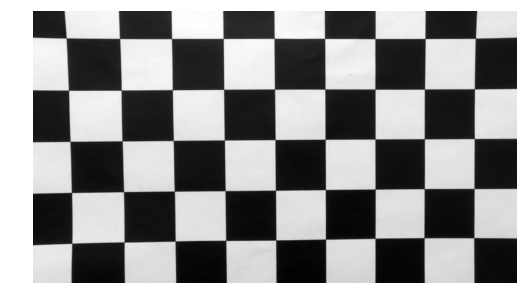

In [6]:
_img = cv2.imread(CAM_CAL_DIR + '/calibration1.jpg')
_img = cv2.cvtColor(_img, cv2.COLOR_BGR2GRAY)
_img = cv2.undistort(_img, Mcam, dist, None, Mcam)
cv2.imwrite(OUT_DIR + '/undistorted.jpg', _img)
plt.imshow(_img, cmap='gray')

Could be better, but we don't have more chessboard images from this camera, so nothing we can do about these imperfections - let's proceed

## Image binarization

In [98]:
def getEdgeFeaturesMap(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    SOBEL_KERNEL = 5
    sobelX = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=SOBEL_KERNEL)
    sobelY = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=SOBEL_KERNEL)
    
    sobelAbsX = np.absolute(sobelX)
    sobelAbsY = np.absolute(sobelY)
    gradMag = np.sqrt(sobelX**2 + sobelY**2)
    absGradDir = np.arctan2(sobelAbsY, sobelAbsX)
    
    gradMag = (255 * gradMag / np.max(gradMag)).astype(np.uint8)

    TH_MAG_MIN = 30
    TH_MAG_MAX = 100
    TH_DIR_MIN = 0.25 * np.pi/2
    TH_DIR_MAX = 0.85 * np.pi/2
    
    out = np.ones_like(gray)
    out[(gradMag < TH_MAG_MIN) | (gradMag > TH_MAG_MAX)] = 0
    out[(absGradDir < TH_DIR_MIN) | (absGradDir > TH_DIR_MAX)] = 0

    return out

def getColorSpaceMap(img):
    imgHls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = imgHls[:,:,0]
    L = imgHls[:,:,1]
    S = imgHls[:,:,2]
    
    TH_S_MIN = 90
    TH_S_MAX = 255
    TH_H_MIN = 15
    TH_H_MAX = 100
    
    out = np.ones_like(S)
    #out[(S < TH_S_MIN) | (S > TH_S_MAX)] = 0
    #out[(H < TH_H_MIN) | (H > TH_H_MAX)] = 0

    return out

def visualizeBinarization():
    fname = IN_DIR + '/straight_lines1.jpg'
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)

    imgEdgesBin = getEdgeFeaturesMap(img)
    imgColorBin = getColorSpaceMap(img)
    imgBothBin = (imgEdgesBin == 1) & (imgColorBin == 1)

    f, axarr = plt.subplots(2, 2, figsize=(15,8))
    axarr[0][0].imshow(img)
    axarr[0][0].set_title('Original')
    axarr[0][1].imshow(imgEdgesBin, cmap='gray')
    axarr[0][1].set_title('Edge features')
    axarr[1][0].imshow(imgColorBin, cmap='gray')
    axarr[1][0].set_title('Color features')
    axarr[1][1].imshow(imgBothBin, cmap='gray')
    axarr[1][1].set_title('Edge AND Color features')

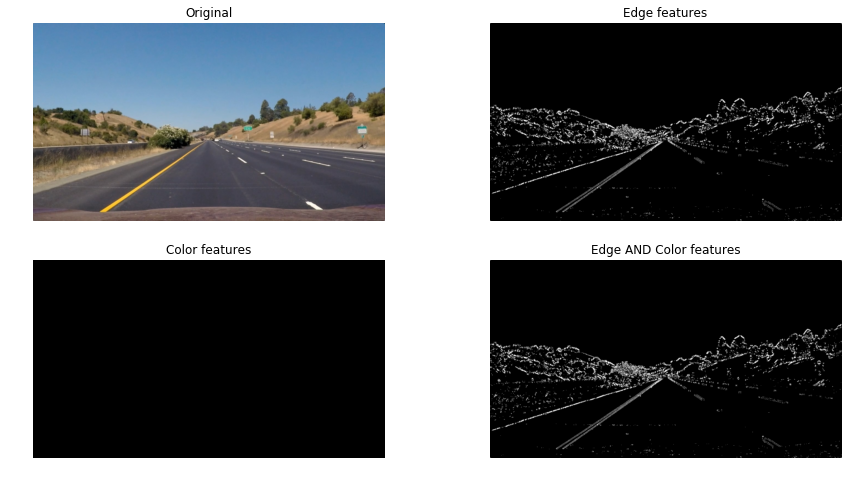

In [99]:
visualizeBinarization()

## Perspective transform (Rectification)

In [100]:
def getRoadSrcPoints(imgSz):
    p_bl = (int(0.00 * imgSz[1]), int(0.93 * imgSz[0]))
    p_br = (int(1.00 * imgSz[1]), int(0.93 * imgSz[0]))
    p_tl = (int(0.435 * imgSz[1]), int(0.63 * imgSz[0]))
    p_tr = (int(0.565 * imgSz[1]), int(0.63 * imgSz[0]))
    return np.float32([p_tl, p_bl, p_br, p_tr])
    
def getRoadDstPoints(imgSz):
    return np.float32([(0,0), (0,imgSz[0]-1), (imgSz[1]-1,imgSz[0]-1), (imgSz[1]-1,0)])
    
def getRectifiedRoadTransform(imgSz):
    srcArr = getRoadSrcPoints(imgSz)
    dstArr = getRoadDstPoints(imgSz)
    Mwarp = cv2.getPerspectiveTransform(srcArr, dstArr)
    MwarpInv = cv2.getPerspectiveTransform(dstArr, srcArr)
    return Mwarp, MwarpInv

def getRectifiedRoad(img):
    Mwarp, _ = getRectifiedRoadTransform(img.shape)
    return cv2.warpPerspective(img, Mwarp, (img.shape[1], img.shape[0]))
    
def drawSrcRoadContour(img, srcArr):    
    srcArr = tuple(map(tuple, srcArr))
    cv2.line(img, srcArr[0], srcArr[1], (255,0,0), 5)
    cv2.line(img, srcArr[1], srcArr[2], (255,0,0), 5)
    cv2.line(img, srcArr[2], srcArr[3], (255,0,0), 5)
    cv2.line(img, srcArr[3], srcArr[0], (255,0,0), 5)
    
def visualizePerspectiveTransform():
    fname = IN_DIR + '/test2.jpg'
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, Mcam, dist, None, Mcam)
    warped = getRectifiedRoad(img)

    imgEdgesBin = getEdgeFeaturesMap(img)
    imgColorBin = getColorSpaceMap(img)
    imgFeatures = (imgEdgesBin == 1) & (imgColorBin == 1)

    imgFeatursWarped = getRectifiedRoad(255 * imgFeatures.astype(np.uint8))
    
    drawSrcRoadContour(img, getRoadSrcPoints(img.shape))

    f, axarr = plt.subplots(2, 2, figsize=(15,8))
    axarr[0][0].imshow(img)
    axarr[0][0].set_title('Original')
    axarr[0][1].imshow(warped)
    axarr[0][1].set_title('Original rectified')
    axarr[1][0].imshow(imgFeatures, cmap='gray')
    axarr[1][0].set_title('Features')
    axarr[1][1].imshow(imgFeatursWarped, cmap='gray')
    axarr[1][1].set_title('Features rectified')    

Below is visualization of the perspective transform operation

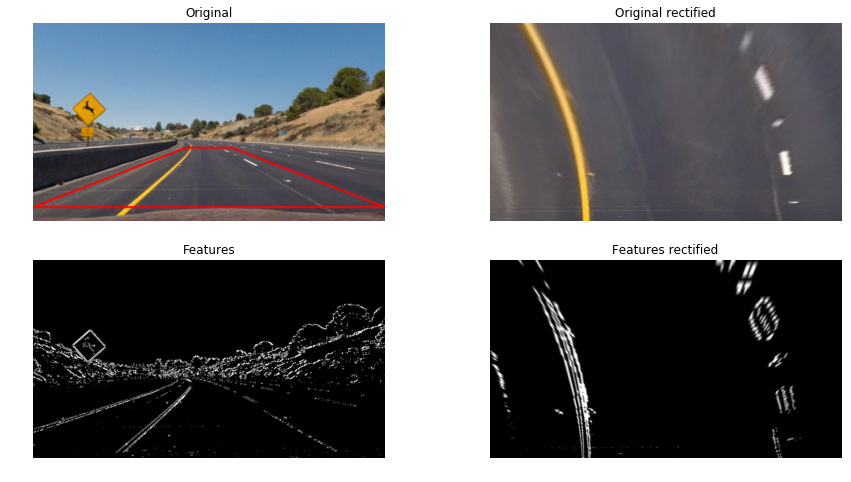

In [101]:
visualizePerspectiveTransform()

## Finding lane lines equations and curvature

In [134]:
# Code for this function is mostly taken from the lecture notes
def fitLineInitialization(binary_warped, bVis):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = None
    if bVis:
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        if bVis:
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if bVis:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        ptsLeft = np.column_stack((left_fitx, ploty)).astype(np.int32)
        ptsRight = np.column_stack((right_fitx, ploty)).astype(np.int32)

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        cv2.polylines(out_img, [ptsLeft], False, (255,255,0), 5)
        cv2.polylines(out_img, [ptsRight], False, (255,255,0), 5)
        
    return left_fit, right_fit, out_img

def calcLaneCurvature(imgFeatursWarped, left_fit, right_fit):
    y_eval = imgFeatursWarped.shape[0]-1
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curverad, right_curverad

def visualizeLaneFindingInitialization():
    fname = IN_DIR + '/test2.jpg'
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, Mcam, dist, None, Mcam)
    imgEdgesBin = getEdgeFeaturesMap(img)
    imgColorBin = getColorSpaceMap(img)
    imgFeatures = (imgEdgesBin == 1) & (imgColorBin == 1)
    imgFeatursWarped = getRectifiedRoad(imgFeatures.astype(np.uint8))

    leftFit, rightFit, imgVis = fitLineInitialization(imgFeatursWarped, True)
    leftCurv, rightCurv = calcLaneCurvature(imgFeatursWarped, leftFit, rightFit)
    
    print('Lane curvatures: left={} right={}'.format(leftCurv, rightCurv))

    f, axarr = plt.subplots(1, 2, figsize=(15,8))
    axarr[0].imshow(img)
    axarr[0].set_title('Original')
    axarr[1].imshow(imgVis)
    axarr[1].set_title('Lane equation initial parameters found')


Lane curvatures: left=1319.6731749440505 right=1164.2049424823465


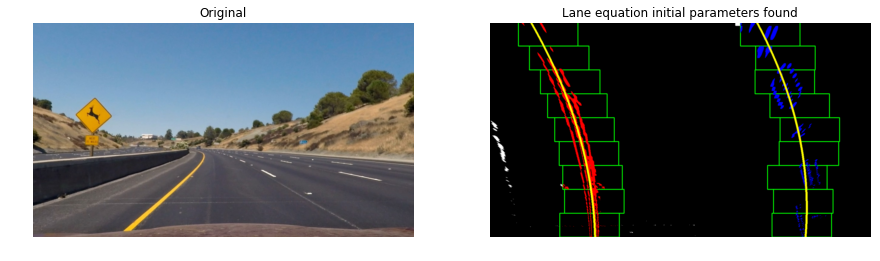

In [135]:
visualizeLaneFindingInitialization()

## Visualizing lane on the original image

In [179]:
def convertLaneFitsToSrcContour(img, leftFit, rightFit):
    plotY = np.linspace(0, img.shape[0]-1, img.shape[0]).reshape(-1,1)

    leftFitX = leftFit[0]*plotY**2 + leftFit[1]*plotY + leftFit[2]
    leftFitY = plotY

    rightFitX = rightFit[0]*plotY**2 + rightFit[1]*plotY + rightFit[2]
    rightFitX = np.flipud(rightFitX)
    rightFitY = np.flipud(plotY)

    _, MwarpInv = getRectifiedRoadTransform(img.shape)
    
    #prepare a closed outline of the detected lane
    plotX = np.vstack((leftFitX, rightFitX))
    plotY = np.vstack((leftFitY, rightFitY))
    ptsDst = np.column_stack((plotX, plotY, np.ones(plotY.shape, dtype=np.float)))
    
    ptsSrc = np.matmul(ptsDst, MwarpInv.T)    
    ptsSrc /= np.column_stack((ptsSrc[:,2], ptsSrc[:,2], ptsSrc[:,2]))
    
    return ptsSrc[:,0:2].astype(np.int32)
    
def visualizeLaneFindingSrcCountour():
    fname = IN_DIR + '/test2.jpg'
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, Mcam, dist, None, Mcam)
    imgEdgesBin = getEdgeFeaturesMap(img)
    imgColorBin = getColorSpaceMap(img)
    imgFeatures = (imgEdgesBin == 1) & (imgColorBin == 1)
    imgFeatursWarped = getRectifiedRoad(imgFeatures.astype(np.uint8))

    leftFit, rightFit, imgVis = fitLineInitialization(imgFeatursWarped, True)
    contourSrc = convertLaneFitsToSrcContour(imgFeatursWarped, leftFit, rightFit)

    imgLaneMask = np.zeros_like(img)
    cv2.fillPoly(imgLaneMask, [contourSrc], (0,255,0))
    imgVis = cv2.addWeighted(img, 1, imgLaneMask, 0.3, 0)
    
    f, axarr = plt.subplots(1, 2, figsize=(15,8))
    axarr[0].imshow(img)
    axarr[0].set_title('Original')
    axarr[1].imshow(imgVis)
    axarr[1].set_title('Lane area overlay')

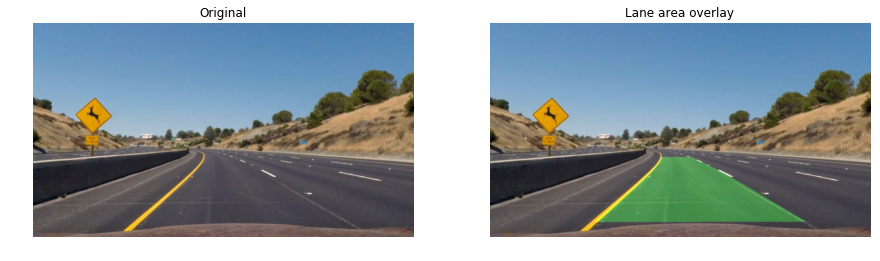

In [180]:
visualizeLaneFindingSrcCountour()

## All steps combined

In [11]:
def processOne(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, Mcam, dist, None, Mcam)
    
    
    return img

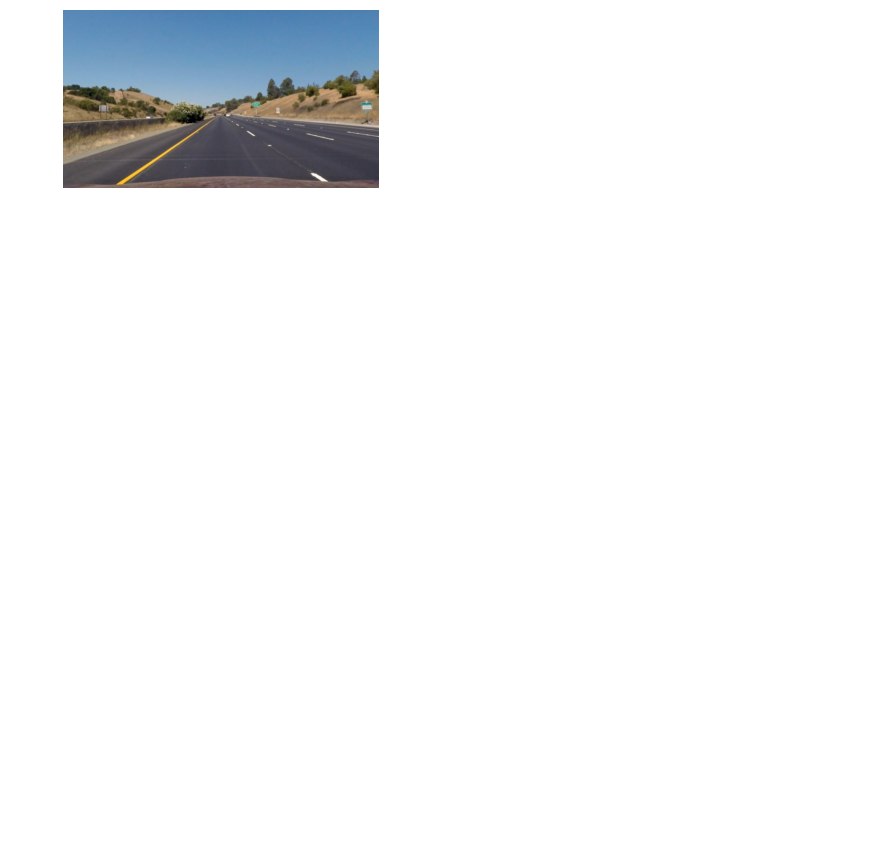

In [12]:
def testPipeline():
    listImages = os.listdir(IN_DIR)
    f, axarr = plt.subplots(len(listImages)//2, 2, figsize=(15,15))
    axarr = axarr.flatten()

    i = 0
    for fname in listImages:
        img = processOne(IN_DIR + '/' + fname)

        axarr[i].imshow(img, cmap=None if len(img.shape) == 3 else 'gray')


        i += 1
        break
    #f.tight_layout()
        
testPipeline()